We have all the ingredients to create a differential equation. We now need the Julia side.

Our notation:

**Tensorflow side**
- `z__l_i`: (notice the 2 underspaces before `l` and 1 before `i`) element `i` of layer `l`
- `w__l_i_j`: weight for input `j` in layer `l-1` into `z__l_i`
- `b__l_i`: bias term for `z__l_i`

**ODE side**
- `z__l_i`: (notice the 2 underspaces before `l` and 1 before `i`) element `i` of layer `l`
- `k__l_i`: negative of `b__l_i`
- `a__l_i`: activating template for `z__l_i`
- `p__l_i`: pseudotemplate for `z__l_i`
- `lambda__l_i_j`: weight for positive input `j` in layer `l-1` into `z__l_i`, given by equation below
- `mu__l_i_j`: weight for negative input `j` in layer `l-1` into `z__l_i`, given by equation below

Differential equations: `__l` becomes a $\cdot^{[l]}$ and `_` becomes a subscript:

$$\frac{dz_i^{[l]}}{dt} = \epsilon + \frac{U a_i^{[l]}z_i^{[l]}}{k_i^{[l]} + z_i^{[l]}} - \frac{V p_i^{[l]}z_i^{[l]}}{k_i^{[l]} + z_i^{[l]}} - \alpha_i^{[l]}z_i^{[l]}$$

$$\frac{da_i^{[l]}}{dt} = \sum_j \lambda_{ij}^{[l]} x_j^{[l-1]} - \beta a_i^{[l]}$$
$$\frac{dp_i^{[l]}}{dt} = \sum_j \mu_{ij}^{[l]} x_j^{[l-1]} - \gamma p_i^{[l]}$$

where $\alpha_i^{[l]} = f(k_i^{[l]})$ for a fixed constant $f$, and
$$\lambda_{ij}^{[l]} = \frac{\beta \alpha_{i}^{[l]}}{U} w_{ij}^{[l]} \mathbb{1}_{w_{ij}^{[l]} > 0}$$
$$\mu_{ij}^{[l]} = -\frac{\gamma \alpha_{i}^{[l]}}{V} w_{ij}^{[l]} \mathbb{1}_{w_{ij}^{[l]} < 0}$$

In [259]:
import tensorflow as tf
import os
import numpy as np

In [2]:
import julia as jl
# jl.install(julia="C:/Users/takes/AppData/Local/Programs/Julia 1.5.2/bin/julia.exe")

In [5]:
from julia import DifferentialEquations

In [8]:
from julia import Main

In [ ]:
DifferentialEquations.ODEProblem()

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# model_folder = 'gdrive/My Drive/Research/Shared with Anthony/Deep Molecular Programming/job_035''

In [12]:
model_folder = '../Research/Shared with Anthony/Deep Molecular Programming/job_035'

In [13]:
model = tf.keras.models.load_model(os.path.join(model_folder, 'model'))

In [11]:
# https://leimao.github.io/blog/Dropout-Explained/
# Dropout in Tensorflow works a bit different from original implementation

In [155]:
ALPHA = 0.03
BETA = 0.01
GAMMA = 0.01
U = 0.01
V = 0.03
EPS = 0.000001

LOG_THRESH = 6
THRESH = 10**(-LOG_THRESH)

In [203]:
# Build W[l,i,j] and k[l,i]
def build_weight_and_bias_dictionaries(model):

    dense_layers = [layer for layer in model.layers if 'dense_' in layer.name]
    W_dict, b_dict = {}, {}
    for ll, layer in enumerate(dense_layers):
        L = ll+1

        w, b = layer.weights
        assert 'kernel:' in w.name
        assert 'bias:' in b.name
        wt, b = w.numpy().T, b.numpy()

        len_wt, len_this_layer = len(wt), len(b)
        assert len_wt == len_this_layer

        for i in range(len_this_layer):
            len_prev_layer = len(wt[0])
            b_dict[(L,i)] = b[i]
            W_dict[(L,i)] = {}
            for j in range(len_prev_layer):
                W_dict[(L,i)][j] = wt[i][j]

    return W_dict, b_dict        

def build_degradation_constants(b):
    # very simple model..
    alpha = {key: ALPHA for key in b.keys()}
    return alpha
        
def build_positive_and_negative_chemical_weights(W, alpha_dict, beta, gamma, U, V):
    
    def w_to_lambda(w, l_i_j):
        l, i, _ = l_i_j
        alpha = alpha_dict[(l,i)]
        return beta * alpha * w / U

    def w_to_mu(w, l_i_j):
        l, i, _ = l_i_j
        alpha = alpha_dict[(l,i)]
        return - gamma * alpha * w / V
    
    lambda_dict, mu_dict = {}, {}
    for l_i, subdict in W.items():
        lambda_dict[l_i] = {}
        mu_dict[l_i] = {}
        for j, w_ij in subdict.items():
            if w_ij > THRESH:
                lambda_dict[l_i][j] = beta * alpha[l_i] * round(w_ij, LOG_THRESH) / U
            elif w_ij < -THRESH:
                mu_dict[l_i][j] = - gamma * alpha[l_i] * round(w_ij, LOG_THRESH) / V
    
    return lambda_dict, mu_dict

In [318]:
W, b = build_weight_and_bias_dictionaries(model)
alpha = build_degradation_constants(b)

In [319]:
lambda_dict, mu_dict = build_positive_and_negative_chemical_weights(W, alpha, BETA, GAMMA, U, V)

We have all the ingredients to create a differential equation:

* Given $(l,i)$ we can immediately write the 3 equations for `z__l_i, a__l_i` and `p__l_i`

[1, 2]

In [420]:
def _var(name, l, i):
    return f"{name}__{l}_{i}_"

def _dvar(name, l, i):
    return "d" + _var(name, l, i) 

def _dvar_to_var(dvar):
    return dvar[1:]

def hidden_layer_list(W):
    return list(set([key[0] for key in W.keys()]))

def last_layer(W):
    return hidden_layer_list(W)[-1]

def nodes_in_layer(W, l):
    ll = l if l > 0 else hidden_layer_list(W)[-1]
    return [key[1] for key in W.keys() if key[0] == ll]

In [376]:
def write_z_ode(b_dict, alpha_dict, l, i):
    
    var_list, dvar_list = [], []
    
    z = _var('z', l, i)
    a = _var('a', l, i)
    p = _var('p', l, i)
    
    dz = _dvar('z', l, i)

    kM = -b_dict[(l,i)]
    alpha = alpha_dict[(l,i)]
    
    dz_ode = f"{dz} = ({EPS} + ({U} * {a} - {V} * {p}) * {z}/({kM} + {z}) - {alpha} * {z})"
    
    # also return which variables and dvariables we have
    var_list.extend([z, a, p])
    dvar_list.append(dz)
    
    return dz_ode, var_list, dvar_list

def write_aT_pT_odes(lambda_dict, mu_dict, alpha_dict, l, i):
    
    lambda_subdict, mu_subdict= lambda_dict[(l,i)], mu_dict[(l,i)]
    
    var_list, dvar_list = [], []

    a = _var('a', l, i)
    p = _var('p', l, i)
    da = _dvar('a', l, i)
    dp = _dvar('p', l, i)
    
    var_list.extend([a, p])
    dvar_list.extend([da, dp])

    # ODE for da/dt
    positive_weight_expr_list = []
    for j, lamb in lambda_subdict.items():
        new_z = _var('z', l-1, j)
        var_list.append(new_z)
        positive_weight_expr_list.append(f"{lamb} * {new_z} ")
    da_ode = f"{da} = (" + "\n            +".join(positive_weight_expr_list) + f"\n            - {BETA} * {a})"
    
    # ODE for dp/dt
    negative_weight_expr_list = []
    for j, mu in mu_subdict.items():
        new_z = _var('z', l-1, j)
        var_list.append(new_z)
        negative_weight_expr_list.append(f"{mu} * {new_z}")
    dp_ode = f"{dp} = ("  + "\n            +".join(negative_weight_expr_list) + f"\n            - {GAMMA} * {p})"
    
    return da_ode, dp_ode, var_list, dvar_list

In [378]:
z_ode, var_list_1, dvar_list_1 = write_z_ode(b, alpha, 1,3)
print(z_ode)

dz__1_3_ = (1e-06 + (0.01 * a__1_3_ - 0.03 * p__1_3_) * z__1_3_/(0.21644003689289093 + z__1_3_) - 0.03 * z__1_3_)


In [379]:
l = 1
var_list_ap = []
dvar_list_ap = []
for i in nodes_in_layer(W, l)[:2]:
    a_ode, p_ode, var_list, dvar_list = write_aT_pT_odes(lambda_dict, mu_dict, alpha, l, i)
    var_list_ap.extend(var_list)
    dvar_list_ap.extend(dvar_list)
    print(a_ode)
    print(p_ode)

da__1_0_ = (0.000691589992493391 * z__0_2_ 
            +0.0002968200109899044 * z__0_6_ 
            +3.476999932900071e-05 * z__0_7_ 
            +0.0007314300164580344 * z__0_9_ 
            +0.006462299823760986 * z__0_12_ 
            +0.0014417399838566778 * z__0_15_ 
            +0.0002366100065410137 * z__0_17_ 
            +0.00034593000076711173 * z__0_18_ 
            +0.0007334099896252154 * z__0_19_ 
            +1.0800000163726507e-05 * z__0_20_ 
            +0.00015426000114530323 * z__0_22_ 
            +0.003345659896731376 * z__0_23_ 
            +0.0001420499989762902 * z__0_24_ 
            - 0.01 * a__1_0_)
dp__1_0_ = (3.9999999899009705e-08 * z__0_0_
            +3.17799998447299e-05 * z__0_1_
            +0.00014859000220894812 * z__0_3_
            +3.225999884307384e-05 * z__0_4_
            +0.00031776998192071913 * z__0_5_
            +6.072999909520149e-05 * z__0_8_
            +0.00015549000352621078 * z__0_10_
            +8.069000206887722e-05 * z__0_11_


## Putting into a format that makes sense for Julia

In [380]:
model = tf.keras.models.load_model(os.path.join(model_folder, 'model'))

In [381]:
W, b = build_weight_and_bias_dictionaries(model)
alpha = build_degradation_constants(b)
lambda_dict, mu_dict = build_positive_and_negative_chemical_weights(W, alpha, BETA, GAMMA, U, V)

In [382]:
def add_tabs(string, nspaces):
    return " "*(nspaces*4) + string

In [383]:
def build_ode_string(W, b, alpha, lambda_dict, mu_dict):
    layer_list = hidden_layer_list(W)
    print(f"Creating script for network with {len(layer_list)} hidden layer(s)")
    
    ode_list, var_list, dvar_list = [], [], []
    for l in layer_list:
        for i in nodes_in_layer(W, l):
            # Calculate ODE for z (add 4 spaces afterwards)
            z_ode, var_list_1, dvar_list_1 = write_z_ode(b, alpha, l, i)
            z_ode = add_tabs(z_ode, 1)
            
            # Calculate ODE for aT, pT (add 4 spaces afterwards)
            a_ode, p_ode, var_list_2, dvar_list_2 = write_aT_pT_odes(lambda_dict, mu_dict, alpha, l, i)
            a_ode = add_tabs(a_ode, 1)
            p_ode = add_tabs(p_ode, 1)
            
            # Add equations to list of equations, and add variables to list of variables
            var_list.extend(var_list_1 + var_list_2)
            dvar_list.extend(dvar_list_1 + dvar_list_2)
            ode_list.extend([z_ode, a_ode, p_ode])
    
    # Keep track of a dictionary mapping each variable to a number, eg. z_4__23: 2
    # this is important because we will input everything in Julia as x[2] so we need
    # to convert the result back to Python afterwards
    enumerated_variables_dict = {var: num+1 for num, var in enumerate(set(var_list))}
    var_to_julia_ode_var_dict = {var: f"x[{n}]" for var, n in enumerated_variables_dict.items()}
    
    full_ode_string = '\n'.join(ode_list)
    for key, val in var_to_julia_ode_var_dict.items():
        full_ode_string = full_ode_string.replace(key, val)
    
    return full_ode_string, enumerated_variables_dict

In [384]:
full_ode_string, enumerated_variables_dict = build_ode_string(W, b, alpha, lambda_dict, mu_dict)

Creating script for network with 2 hidden layer(s)


In [385]:
from collections import OrderedDict

In [406]:
def build_initial_conditions(enumerated_variables_dict):
    # We need to teach this guy how to really create initial conditions;
    # for now make it random
    from collections import OrderedDict
    
    initial_conditions_dict = {}
    for var, n in enumerated_variables_dict.items():
        initial_conditions_dict[n] = np.random.uniform() if 'z__0' in var else 1e-9
    
    ordered_initial_conditions = OrderedDict(sorted(initial_conditions_dict.items()))
    return list(ordered_initial_conditions.values())

In [392]:
initial_conditions = build_initial_conditions(enumerated_variables_dict)

In [393]:
def create_julia_file_body(full_ode_string, initial_conditions, output_file):
    string = "using DifferentialEquations\nusing DataFrames\nusing CSV"
#     string+= "\nprintln(333)\n"
    string+= "\n\nfunction f!(dx, x, p, t)\n"
    string+= full_ode_string
    string+= "\nend"
    string+= f"\nx0 = {initial_conditions}\ntspan = (0.0,1000.0)"
#     string += "\n\nfunction f!(dx, x, p, t)"
#     string += "\n    dx = - 0.3 * x\nend"
#     string += "\nx0 = 3\ntspan=(0.0,2.0)"
    
    string+= "\nprob=ODEProblem(f!,x0,tspan)"
#     string+= "\nprintln(444)"
    string+= "\nsol=solve(prob)"
    string+= "\ndf = DataFrame(sol)"
    string+= f"\nCSV.write(\"{output_file}\",df)"
    return string

In [394]:
myfile_body = create_julia_file_body(full_ode_string, initial_conditions, "test_output.csv")
with open('output.jl', 'w') as f:
    f.write(myfile_body)

In [ ]:
os.system('julia output.jl')

Read output and find how the outputs varied

In [407]:
df = pd.read_csv("test_output.csv")

In [432]:
def get_output_variables(W, enumerated_variables_dict):
    last_layer_l = last_layer(W)
    last_layer_nodes_i = nodes_in_layer(W,last_layer_l)

    output_var_names = [_var('z', last_layer_l, i) for i in last_layer_nodes_i]
    
    return [enumerated_variables_dict[var] for var in set(output_var_names)]

In [440]:
df_out = df.loc[get_output_variables(W, enumerated_variables_dict)].T
df_out = df_out.rename({col: i for i, col in enumerate(df_out.columns)}, axis=1)
df_out.index = range(len(df_out))

<AxesSubplot:>

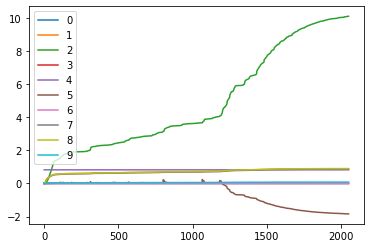

In [442]:
df_out.plot()

In [14]:
# Installing Julia wrapper: https://towardsdatascience.com/run-native-julia-code-with-python-92d3e1079385
# On Julia prompt:
# using Pkg; Pkg.add("PyCall")
# build "PyCall"
# On Anaconda (conda didnt work, used pip)
# pip3 install julia